# Machine Translation

English-German Translation using classic encoder-decoder model

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [0]:
import pandas as pd 
import string 
import pickle
from pickle import dump
from pickle import load
from string import digits
import re 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from numpy import array, argmax, random, take 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [4]:
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Input,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 

Using TensorFlow backend.


In [5]:
!  pip install version_information

In [6]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,re,sklearn, matplotlib,keras

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
re 2.2.1
sklearn 0.21.3
matplotlib 3.0.3
keras 2.2.5
Mon Sep 16 17:02:18 2019 UTC

# 2)- Reading Dataset

In [0]:
df= pd.read_table('random_data.txt', names=['eng','ger'])

In [8]:
df.shape

(6507, 2)

In [9]:
df[30:35]

,eng,ger
30,when the united states occupied japan after world war ii general douglas macarthur and his aides encouraged the country to adopt a constitution designed to assure that hideki tojos militarized aut...,als die vereinigten staaten nach dem zweiten weltkrieg japan besetzte ermutigten general douglas mac arthur und sein stab das land dazu eine verfassung zu verabschieden die sicherstellen solle das...
31,fully aware that workers and their unions had a role to play in shaping the new japan they included language that explicitly recognized that the right of workers to organize and to bargain and act...,in vollem bewusstsein dessen dass die arbeiter und ihre gewerkschaften bei der schaffung eines neuen japan eine rolle einnahmen verwendeten sie eine sprache die explizit anerkannte dass die rechte...
32,when the united states occupied germany after world war ii general dwight david eisenhower and his aides urged the germans to write a constitution that would assure that adolf hitlers fascism was ...,als die vereinigten staaten nach dem zweiten weltkrieg deutschland besetzen drangten general dwight david eisenhower und sein stab die deutschen eine verfassung zu schreiben die dafur sorgen wurde...
33,recognizing that workers would need to organize and make their voices heard in the new nation the germans included a provision that explicitly declared the right to form associations to safeguard ...,in anerkennung der tatsache dass die arbeiter sich wurden organisieren mussen und ihre stimme in der neuen nation erheben sollten fugten die deutschen eine klausel ein die explizit aussagte das re...
34,agreements that restrict or seek to impair this right shall be null and void measures directed to this end shall be unlawful,vereinbarungen die dieses recht einschranken oder darauf abzielen es zu schmalern sind null und nichtig darauf abzielende manahmen sind ungesetzlich


# 3)- Quick Preprocessing

In [0]:
# Lowercase all characters
df.eng=df.eng.apply(lambda x: x.lower())
df.ger=df.ger.apply(lambda x: x.lower())

In [0]:
# Remove quotes
df.eng=df.eng.apply(lambda x: re.sub("'", '', x))
df.ger=df.ger.apply(lambda x: re.sub("'", '', x))

In [0]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df.eng=df.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df.ger=df.ger.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df.eng=df.eng.apply(lambda x: x.translate(remove_digits))
df.ger=df.ger.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
df.eng=df.eng.apply(lambda x: x.strip())
df.ger=df.ger.apply(lambda x: x.strip())
df.eng=df.eng.apply(lambda x: re.sub(" +", " ", x))
df.ger=df.ger.apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences. This will make ensure that we know when to end our decoding seq. in interfernce alogorithm
df.ger = df.ger.apply(lambda x : 'START_ '+ x + ' _END')

In [16]:
df.ger[70:73]

70    START_ dr jordan sagte dass das alter einer frau bei der diagnose der typ des eierstockkrebses bestehende vorerkrankungen sowie der soziale und wirtschaftliche status ebenfalls die uberlebenschanc...
71                                                    START_ fur altere frauen und diejenigen deren krebs zum diagnosezeitpunkt bereits weiter fortgeschritten war lag die uberlebensrate am niedrigsten _END
72              START_ fur diejenigen die in landlichen und abgelegenen regionen des staates lebten lag das sterblichkeitsrisiko wahrend der studie um prozent hoher als fur diejenigen in stadtgebieten _END
Name: ger, dtype: object

In [17]:
df.sample(10)

,eng,ger
1482,tony stewart crashes in return to track,START_ tony stewart erleidet unfall bei ruckkehr auf die rennstrecke _END
954,i lost many people i knew well and they were dear for me,START_ ich habe viele menschen verloren die ich gut kannte und die mir teuer waren _END
4684,since he won critical acclaim for his othello he has become engrossed in the theatre,START_ seit er von den kritikern fur seinen othello gelobt wurde ist er vom theater vereinnahmt _END
2387,at the other end of the scale was canberra hit by government spending cutbacks where prices rose by only per cent through the year,START_ am anderen ende der skala liegt canberra das von den einschnitten bei staatlichen ausgaben hart getroffen wurde und wo die preise uber das jahr lediglich um prozent anstiegen _END
2995,damir was later flown to london by the now defunct news of the world newspaper to be crowned a barnardos childrens champion by then premier tony blair and wife wife cherie,START_ damir wurde spater nach london geflogen von der inzwischen aufgelosten zeitung news of the world um vom damaligen premier tony blair und seiner frau cherie den titel eines barnardos childre...
6255,the girl and man went hiking just after midday on sunday at govetts leap in blackheath,START_ das madchen und der mann brachen kurz nach sonntagmittag in govetts leap in blackheath zu ihrer tour auf _END
6258,the girl had injured her knee and the man had fallen and hit his head,START_ das madchen hatte sich am knie verletzt und der mann war gesturzt und hatte seinen kopf aufgeschlagen _END
5744,the roman legionnaire will for example talk about his drafty work in wachtberg plants will be presented as living monuments of roman times and a humorous lesson on the matter of international unde...,START_ dabei wird zum beispiel ein romischer legionar von seiner arbeit auf dem zugigen wachtberg erzahlen pflanzen als lebende denkmale aus der romerzeit vorgestellt und eine witzige lehrstunde i...
3847,the administration of the province of guangdong whose capital city is guangzhou is also hoping for a flight connection,START_ auch die verwaltung der provinz guangdong deren hauptstadt guangzhou ist hofft auf die flugverbindung _END
2693,her career began at global management consultants bain and co then progressed via morgan stanley bombadier ici and the media world of pearsons,START_ ihre karriere begann bei dem weltweiten managementberatungsunternehmen bain and co worauf sie zu morgan stanley bombadier ici und die medienwelt von pearsons wechselte _END


### 3a)- Vocab Size

compute the vocabulary for both English(input) and German(target)

In [0]:
# Vocabulary of English
all_eng_words=set()
for eng in df.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
# Vocabulary of German 
all_german_words=set()
for ger in df.ger:
    for word in ger.split():
        if word not in all_german_words:
            all_german_words.add(word)

**compute the vocabulary sizes and the length of maximum sequence for both the languages**

In [19]:
# Max Length of source sequence
import numpy as np
lenght_list=[]
for l in df.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

71

In [20]:
# Max Length of target sequence
lenght_list=[]
for l in df.ger:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

73

In [21]:
df['word_eng'] = df['eng'].apply(lambda x: len(str(x).split(" ")))
df[['eng','word_eng']].sample(3)

,eng,word_eng
3955,this ice bucket challenge went painfully wrong,7
3617,the gun club tannenwald in berngau is celebrating its anniversary from to september,13
284,after registering at the fraternitys club house sta,8


In [22]:
# adding +2 due to adding of START and END
df['word_ger'] = df['ger'].apply(lambda x: len(str(x).split(" ")))
df[['ger','word_ger']].sample(3)

,ger,word_ger
5157,START_ voller angst sie konne tot sein floh er und sah auf dem weg ein weinendes kleinkind ergriff es bei der hand und floh durch einen kugelhagel _END,28
2010,START_ wie bei fruheren serien der mainpost in vergangenen jahren gibt es auch heuer wieder preise zu gewinnen wenn sie die richtige losung haben _END,25
5435,START_ plotzlich hatte ich schuttelfrost _END,6


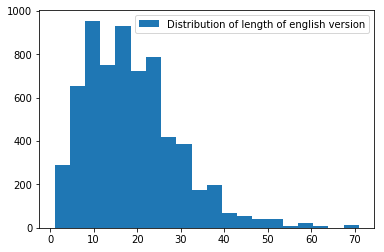

In [23]:
words_eng=df['word_eng']
plt.hist(words_eng, bins=20, label="Distribution of length of english version") 
plt.legend() 
plt.show()

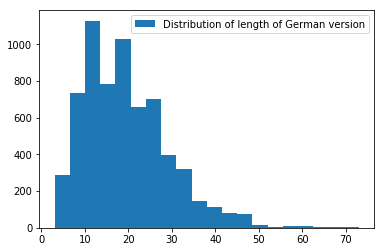

In [24]:
words_ger=df['word_ger']
plt.hist(words_ger, bins=20, label="Distribution of length of German version") 
plt.legend() 
plt.show()

### 3b)-Words' frequency

In [25]:
# let’s check the 10 most frequently occurring words in our English text data
freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[:10]
freq_eng

the     7929
to      3345
of      3234
in      3045
and     2859
a       2709
for     1269
that    1230
is      1200
was     1146
dtype: int64

In [26]:
freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[:12]
freq_ger

START_    6507
_END      6507
die       3768
der       3531
und       2820
in        2370
den       1359
von       1299
das       1278
zu        1218
fur        999
dass       996
dtype: int64

As we have start and end words so, I did check 12 so that we get idea of most fequent words

**How about least occuring words**

In [27]:
less_freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[-10:]
less_freq_eng

rounds          3
contradicted    3
ploy            3
giorgio         3
forever         3
defeats         3
dame            3
dundee          3
nitric          3
gottingens      3
dtype: int64

In [28]:
less_freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[-10:]
less_freq_ger

wesentliches                   3
verfahrensmechaniker           3
missbilligung                  3
gemerkt                        3
vorderreifen                   3
leichte                        3
ausgetauscht                   3
lebenserhaltungsmechanismus    3
upper                          3
wachsende                      3
dtype: int64

### 3c)- Defining input and target

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_german_words))


**Calculate Vocab size for both source and target**

In [30]:
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_german_words)
print(num_encoder_tokens) 
print(num_decoder_tokens)

7230
9285


**We will shift the target data by 1 since we have appended ‘Start_’ in the German sentences**

In [31]:
num_decoder_tokens += 1 
num_decoder_tokens

9286

**Creating word to token dictionary for both source and target**

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

**Create token to word dictionary for both source and target**

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
#print(reverse_input_char_index)

In [0]:
#print(reverse_target_char_index)

### 3d)-Train - Test Split

For validation

90%-10%

In [36]:
X, y = df.eng, df.ger #X being input, y being target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=2019)
X_train.shape, X_test.shape

((5856,), (651,))

**Save the train and test dataframes for reproducing the results later, as they are shuffled**

In [0]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

**function to load the data in batches**

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# 4)-Encoder - Decoder Model Architecture

In [0]:
latent_dim = 50

**Encoder sode**

In [40]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**decoder side**

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

**compile model**

In [42]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

**Note our number of decoder tokens are 9286. Rest I have used same latent dimension i.e embedding layer of 50**

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     361500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     464300      input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 

In [46]:
history=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint],
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


Epoch 1/50
45/45 [==============================] - 32s 707ms/step - loss: 8.0039 - acc: 0.0525 - val_loss: 7.2547 - val_acc: 0.0557

Epoch 00001: val_loss improved from inf to 7.25474, saving model to model_translate.h1
Epoch 2/50
45/45 [==============================] - 29s 634ms/step - loss: 7.1417 - acc: 0.0550 - val_loss: 7.1617 - val_acc: 0.0544

Epoch 00002: val_loss improved from 7.25474 to 7.16171, saving model to model_translate.h1
Epoch 3/50
45/45 [==============================] - 29s 639ms/step - loss: 7.0923 - acc: 0.0550 - val_loss: 7.1252 - val_acc: 0.0548

Epoch 00003: val_loss improved from 7.16171 to 7.12520, saving model to model_translate.h1
Epoch 4/50
45/45 [==============================] - 29s 634ms/step - loss: 7.0265 - acc: 0.0550 - val_loss: 7.0630 - val_acc: 0.0552

Epoch 00004: val_loss improved from 7.12520 to 7.06299, saving model to model_translate.h1
Epoch 5/50
45/45 [==============================] - 29s 635ms/step - loss: 6.9542 - acc: 0.0548 - val_l

In [0]:
# save model
model.save_weights('model_translate.h5')

In [0]:
model.load_weights('model_translate.h5')

# 5)-Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
  

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# 6)-Evaluation on Train Dataset

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [56]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual German Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted German Translation:', decoded_sentence[:-4])

Input English sentence: this zest for like already beams out of mr li he said flattering the host
Actual German Translation:  diese lebensfreude strahle bereits herr li aus schmeichelte er dem gastgeber 
Predicted German Translation:  das cruise nach der zweiten spielte wurde und die flugh


In [57]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual German Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted German Translation:', decoded_sentence[:-4])

Input English sentence: pupils perched their bunsen burners on asbestos mats
Actual German Translation:  schuler stellten ihre bunsenbrenner auf asbestmatten ab 
Predicted German Translation:  lenny und die nachmittag aus dem mutter aus 


# 7)-Evaluation on Validation Dataset

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [59]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual German Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted German Translation:', decoded_sentence[:-4])

Input English sentence: if we are in real big trouble then i might consider it the twotime father told the magazine
Actual German Translation:  wenn alle stricke reien bin ich immer gesprachsbereit erklarte der zweifache familienvater dem fachmagazin 
Predicted German Translation:  es ist es ist dass die menschen und die schule


# 8)- Plotting results

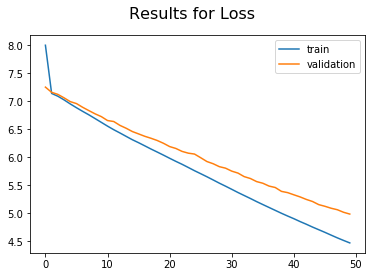

In [53]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Loss', fontsize=16)
plt.show()

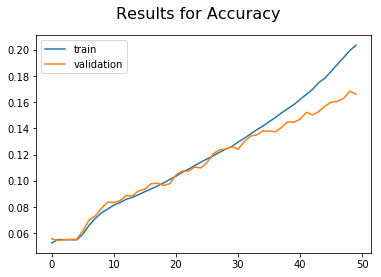

In [54]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Accuracy', fontsize=16)
plt.show()